,Model,Best Params,CV F1-score (mean±std),Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Random Forest,"{'max_depth': 5, 'n_estimators': 100}",0.878±0.059,0.853333,0.853333,0.853333,0.853333,0.9280
1,Gradient Boosting,"{'max_depth': 3, 'n_estimators': 200}",0.897±0.035,0.880000,0.890411,0.866667,0.878378,0.9248
2,SVM (RBF),"{'C': 10, 'gamma': 'auto'}",0.924±0.023,0.933333,0.922078,0.946667,0.934211,0.9504


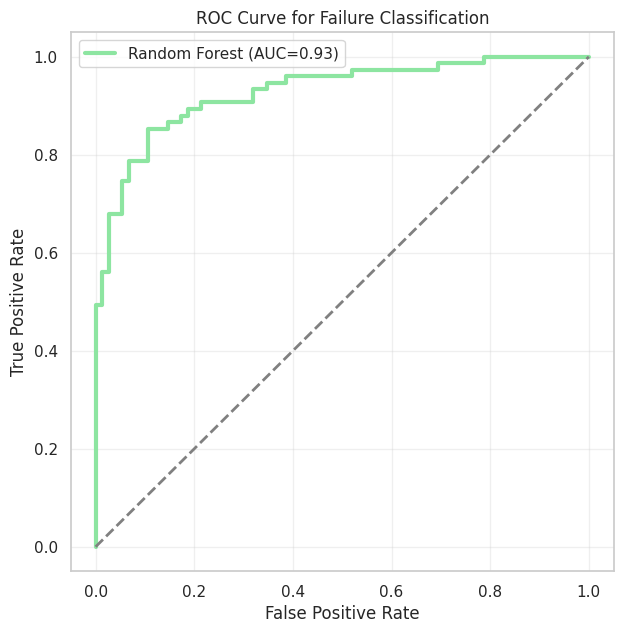

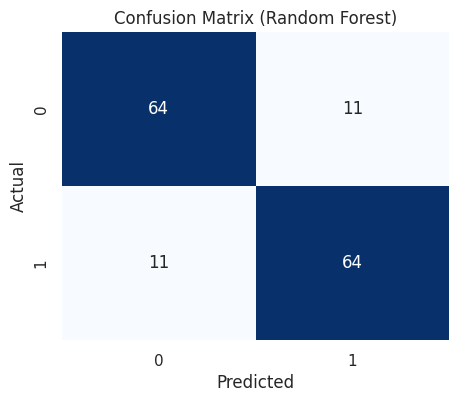


Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        75
           1       0.85      0.85      0.85        75

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,KMeans,0.188691,1.648793,126.843477
1,DBSCAN,NaN,NaN,NaN


/tmp/ipython-input-1-3109241293.py:189: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




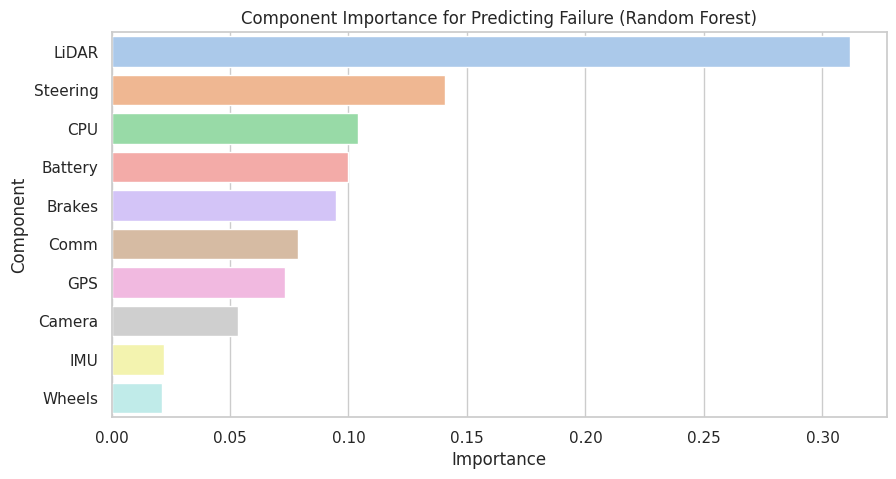

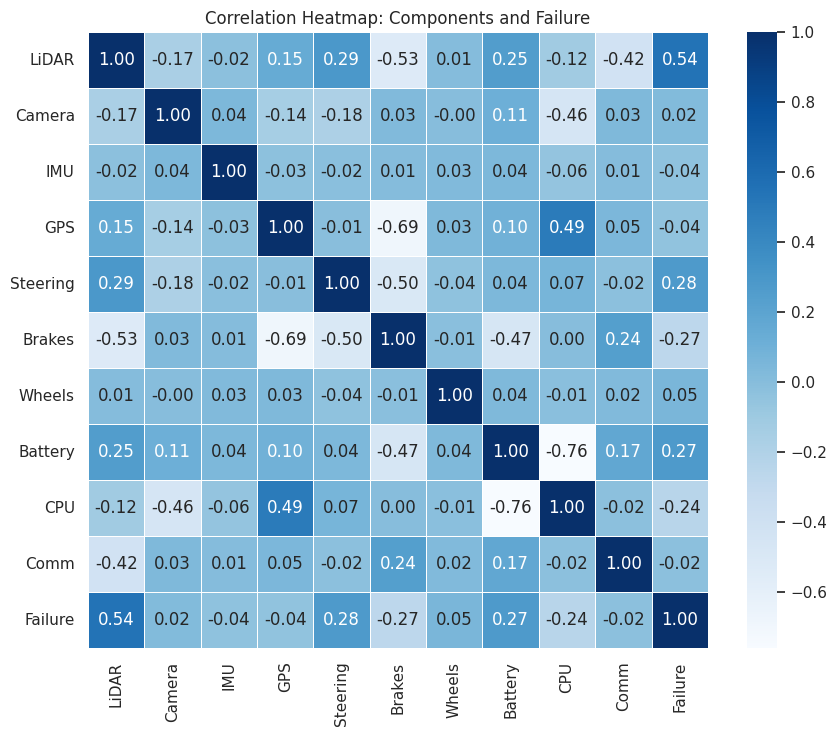

,No Failure,Failure,Difference
LiDAR,-0.942,1.081,2.024
Steering,-0.987,-0.002,0.985
Battery,0.019,0.970,0.951
Wheels,-0.030,0.080,0.109
Camera,0.019,0.083,0.064
Comm,-0.920,-0.977,-0.057
IMU,0.002,-0.072,-0.074
GPS,0.134,-0.022,-0.156
CPU,-0.132,-1.003,-0.871
Brakes,0.081,-1.279,-1.359


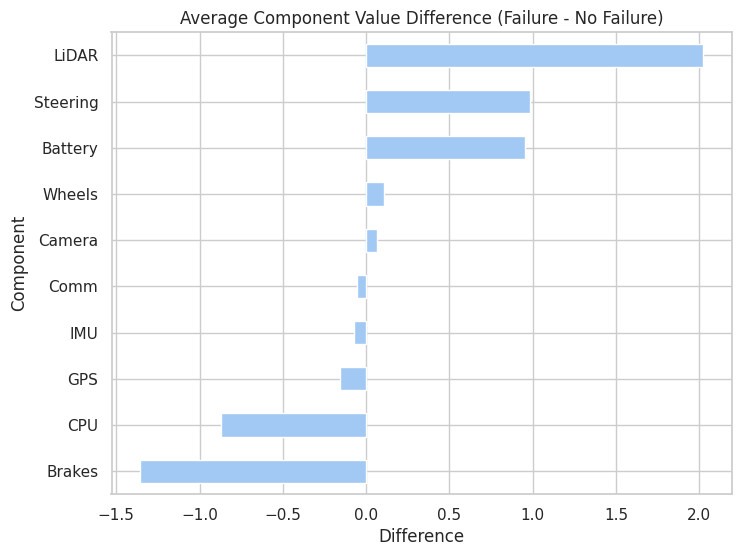

/tmp/ipython-input-1-3109241293.py:218: UserWarning:

The palette list has more values (8) than needed (4), which may not be intended.



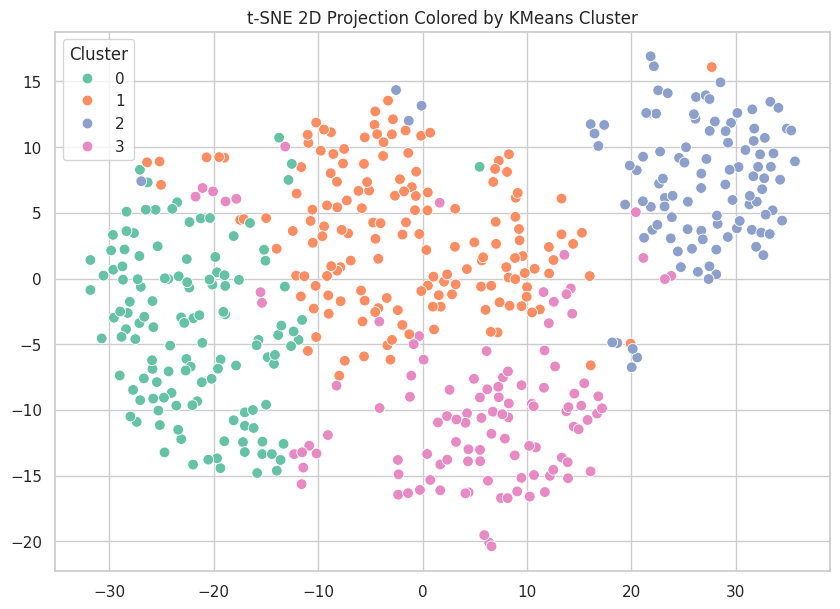

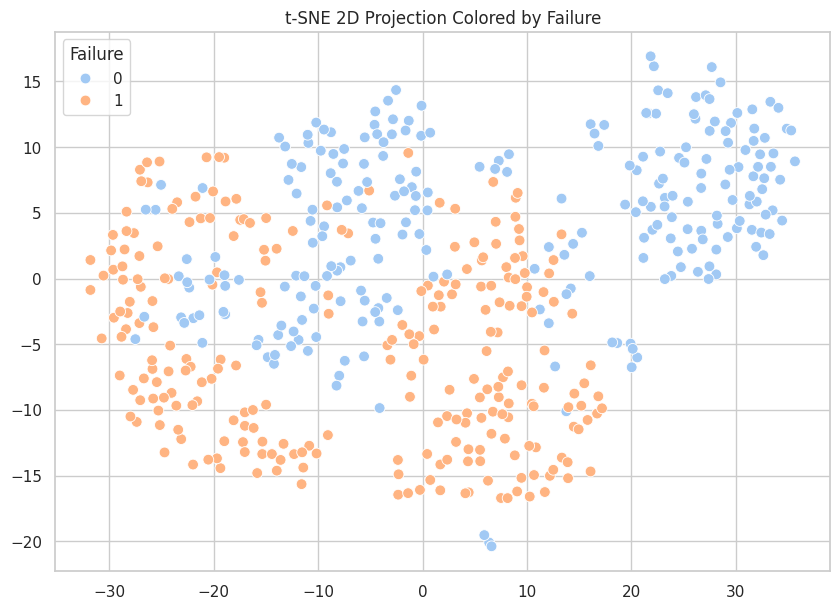

,Model,Precision,Recall,F1-score
0,Isolation Forest,0.48,0.096,0.16


,No Failure (%),Failure (%)
row_0,,
0,28.35,71.65
1,58.23,41.77
2,99.05,0.95
3,16.36,83.64


In [1]:

!pip install scikit-learn matplotlib seaborn plotly --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import plotly.express as px

# --- COLOR PALETTES ---
sns.set_theme(style="whitegrid")
light_palette = sns.color_palette("pastel")
cluster_palette = sns.color_palette("Set2", 8)
pastel_colors = ["#A1C9F4", "#FFB482", "#8DE5A1", "#FF9F9B", "#D0BBFF",
                 "#DEBB9B", "#FAB0E4", "#CFCFCF", "#FFFEA3", "#B9F2F0"]

# --- DATA PREPARATION (Replace with your real data) ---
X, y = make_classification(n_samples=500, n_features=10, n_informative=6, n_redundant=2, random_state=42)
component_names = ['LiDAR', 'Camera', 'IMU', 'GPS', 'Steering', 'Brakes', 'Wheels', 'Battery', 'CPU', 'Comm']
df = pd.DataFrame(X, columns=component_names)
df['Failure'] = y

# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(df[component_names], df['Failure'], test_size=0.3, random_state=42, stratify=df['Failure'])

# --- CROSS-VALIDATION & HYPERPARAMETER TUNING ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# Gradient Boosting
gb_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 10]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=cv, scoring='f1', n_jobs=-1)
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_

# SVM (RBF)
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42), svm_param_grid, cv=cv, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_

# --- CROSS-VALIDATED RESULTS TABLE ---
def cv_results(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return scores.mean(), scores.std()

rf_cv_mean, rf_cv_std = cv_results(rf_best, X_train, y_train, cv)
gb_cv_mean, gb_cv_std = cv_results(gb_best, X_train, y_train, cv)
svm_cv_mean, svm_cv_std = cv_results(svm_best, X_train, y_train, cv)

# --- FINAL TEST SET EVALUATION ---
def test_metrics(model, X, y, y_true):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

rf_test = test_metrics(rf_best, X_test, y_test, y_test)
gb_test = test_metrics(gb_best, X_test, y_test, y_test)
svm_test = test_metrics(svm_best, X_test, y_test, y_test)

# --- SUMMARY TABLE ---
summary_df = pd.DataFrame([
    {
        "Model": "Random Forest",
        "Best Params": str(rf_grid.best_params_),
        "CV F1-score (mean±std)": f"{rf_cv_mean:.3f}±{rf_cv_std:.3f}",
        **rf_test
    },
    {
        "Model": "Gradient Boosting",
        "Best Params": str(gb_grid.best_params_),
        "CV F1-score (mean±std)": f"{gb_cv_mean:.3f}±{gb_cv_std:.3f}",
        **gb_test
    },
    {
        "Model": "SVM (RBF)",
        "Best Params": str(svm_grid.best_params_),
        "CV F1-score (mean±std)": f"{svm_cv_mean:.3f}±{svm_cv_std:.3f}",
        **svm_test
    }
])
display(summary_df)

# --- ROC CURVE FOR BEST MODEL ---
y_proba = rf_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color=light_palette[2], lw=3, label=f'Random Forest (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Failure Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- CONFUSION MATRIX ---
y_pred = rf_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- CLASSIFICATION REPORT ---
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred))

# --- UNSUPERVISED LEARNING: CLUSTERING & ANOMALY DETECTION ---
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(df[component_names]) # Uncommented this line
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(df[component_names]) # Uncommented this line
iso = IsolationForest(contamination=0.1, random_state=42)
anomaly_scores = iso.fit_predict(df[component_names])
df['Anomaly'] = (anomaly_scores == -1).astype(int)

# --- CLUSTERING METRICS TABLE ---
sil_score = silhouette_score(df[component_names], kmeans_labels)
db_score = davies_bouldin_score(df[component_names], kmeans_labels)
ch_score = calinski_harabasz_score(df[component_names], kmeans_labels)
clustering_metrics = pd.DataFrame({
    "Model": ["KMeans", "DBSCAN"],
    "Silhouette Score": [sil_score, None],
    "Davies-Bouldin Index": [db_score, None],
    "Calinski-Harabasz Index": [ch_score, None]
})
display(clustering_metrics)

# --- 3D VISUALIZATION: PCA for Features/Clusters/Anomalies ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df[component_names])

fig1 = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    color=df['Failure'].astype(str),
    color_discrete_sequence=pastel_colors,
    title="3D PCA Projection Colored by Failure",
    labels={'color': 'Failure'}
)
fig1.show()

fig2 = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    color=df['Anomaly'].astype(str),
    color_discrete_sequence=pastel_colors,
    title="3D PCA Projection Colored by Anomaly",
    labels={'color': 'Anomaly'}
)
fig2.show()

fig3 = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    color=kmeans_labels.astype(str),
    color_discrete_sequence=pastel_colors,
    title="3D PCA Projection Colored by KMeans Cluster",
    labels={'color': 'Cluster'}
)
fig3.show()

# --- FEATURE IMPORTANCE ---
importances = rf_best.feature_importances_
feat_imp = pd.Series(importances, index=component_names).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="pastel")
plt.title("Component Importance for Predicting Failure (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Component")
plt.show()

# --- HEATMAP: COMPONENTS AND FAILURE ---
corr = df[component_names + ['Failure']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Components and Failure")
plt.show()

# --- GROUP MEANS: WHICH COMPONENTS ARE FAILURE-PRONE? ---
group_means = df.groupby('Failure')[component_names].mean().T
group_means.columns = ['No Failure', 'Failure']
group_means['Difference'] = group_means['Failure'] - group_means['No Failure']
display(group_means.sort_values('Difference', ascending=False).round(3))

group_means['Difference'].sort_values().plot(kind='barh', color=light_palette[0], figsize=(8,6))
plt.title("Average Component Value Difference (Failure - No Failure)")
plt.xlabel("Difference")
plt.ylabel("Component")
plt.show()

# --- t-SNE 2D Visualization for Clusters and Failures ---
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df[component_names])
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans_labels, palette=cluster_palette, s=60)
plt.title("t-SNE 2D Projection Colored by KMeans Cluster")
plt.legend(title="Cluster")
plt.show()

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['Failure'], palette=sns.color_palette("pastel", 2), s=60)
plt.title("t-SNE 2D Projection Colored by Failure")
plt.legend(title="Failure")
plt.show()

# --- ANOMALY DETECTION TABLE ---
iso_precision = precision_score(df['Failure'], df['Anomaly'])
iso_recall = recall_score(df['Failure'], df['Anomaly'])
iso_f1 = f1_score(df['Failure'], df['Anomaly'])
anomaly_metrics = pd.DataFrame({
    "Model": ["Isolation Forest"],
    "Precision": [iso_precision],
    "Recall": [iso_recall],
    "F1-score": [iso_f1]
})
display(anomaly_metrics.round(3))

# --- EXTRA: Parallel Coordinates Plot for Patterns by Failure ---
fig = px.parallel_coordinates(
    df, color="Failure",
    color_continuous_scale=px.colors.sequential.Viridis, # Replaced Pastel with Viridis
    labels={col:col for col in component_names},
    title="Parallel Coordinates: Component Patterns by Failure"
)
fig.show()

# --- EXTRA: Failure Rate by Cluster Table ---
cluster_failure_rate = pd.crosstab(kmeans_labels, df['Failure'], normalize='index') * 100
cluster_failure_rate.columns = ['No Failure (%)', 'Failure (%)']
display(cluster_failure_rate.round(2))

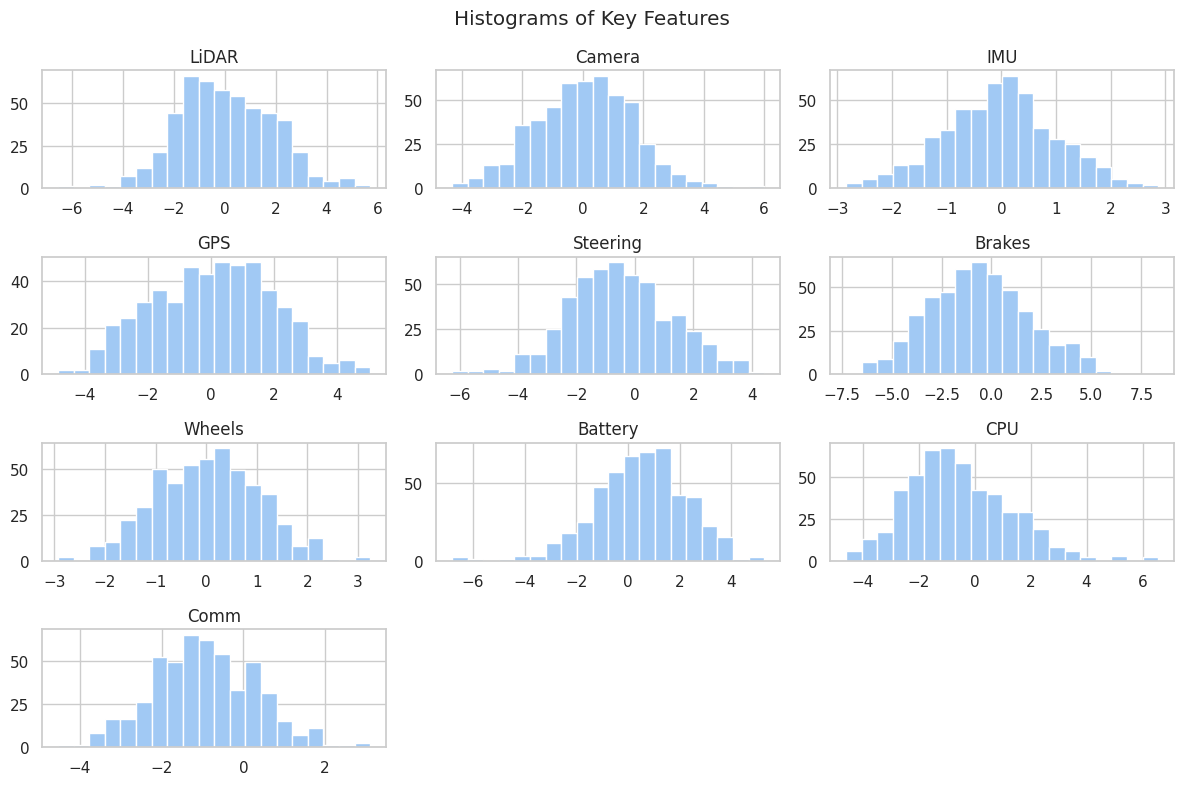

In [ ]:
df[component_names].hist(bins=20, figsize=(12, 8), color=light_palette[0])
plt.suptitle("Histograms of Key Features")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()